<a href="https://colab.research.google.com/github/jdscifi/AutoCaptcha/blob/developement/Preliminary_Analysis_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import logging
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import os
import pandas as pd
import random
import string

In [ ]:
import logging
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import pandas as pd

In [ ]:
logging.basicConfig(filename='AutoCaptcha.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s')
EXPECTEDIMAGEWIDTH = 1000

# Total dataset: 95,486

<AxesSubplot:title={'center':'Character Occurrance'}>

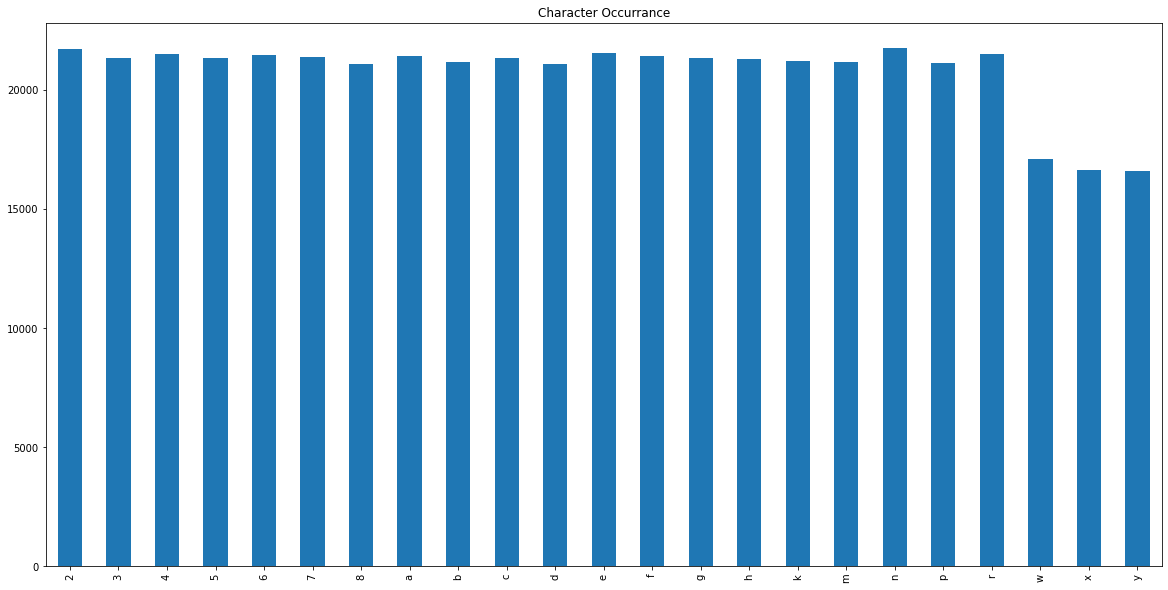

In [ ]:
characterList = []
datasetPath = r"C:\Users\jaydu\Documents\Durham\Capstone Group 5\Auto Captcha\datasetImages\set6\captcha_images"
for root,dre, files in os.walk(datasetPath):
    # print("Total dataset",len(files))
    for name in files:
        characterList.extend(list(name.replace(".png","")))
df = pd.DataFrame({"characters":characterList})
characterData = df.characters.value_counts().sort_index()
characterData.plot.bar(title="Character Occurrance",figsize=(20,10))

In [ ]:
characterData.to_csv("character.csv")

In [ ]:
characterData.shape

(23,)

### Note: Many character are avoided by major technologies like BotDetect, because they can be eaily confused for each other
### For example (0,o),(1,i,j), etc....
#### Hence out of the expected 36 characters only 23 characters are present

# Image Pre Processing includes 
## 1) Thresholding images such that pixels above 75 are converted to 0 to make lines darker
## 2) Dilating the image is done to eliminate the distortion line
## 3) Eroding brings back the pixel thicknes
## 4) Sharpening makes the edges easier
## 5) Binary thresholding does is a final step before image segmentation

In [ ]:
class AutoCaptcha:
    kernel = np.ones((3, 3), np.uint8)
    def __init__(self, imagePath="", label = ""):
        try:
            # use the image object for your operations
            self.imageObject = cv2.imread(imagePath,cv2.IMREAD_UNCHANGED)
            #make mask of where the transparent bits are
            trans_mask = self.imageObject[:,:,3] == 0
            self.imageLabel = label
            #replace areas of transparency with white and not transparent
            self.imageObject[trans_mask] = [255, 255, 255, 255]

            #new image without alpha channel...
            self.imageObject = cv2.cvtColor(self.imageObject, cv2.COLOR_BGRA2BGR)
            # self.ImageShow()
            self.imageObject = cv2.cvtColor(self.imageObject, cv2.COLOR_BGR2GRAY)
        except Exception as e:
            logging.exception("Exception Image constructor", exc_info=True)
            print(e)
    
    def ImageThresholding(self,thresholdType,thresholdValue):
        try:
            ret,self.imageObject = cv2.threshold(self.imageObject,thresholdValue,255,thresholdType)
        except Exception as e:
            logging.exception("Exception Image constructor", exc_info=True)
            print(e)

    def ImageShow(self):
        try:
            plt.imshow(self.imageObject)
            plt.show()
            #cv2.imshow('image', self.imageObject)
            #cv2.waitKey(0)
        except Exception as e:
            logging.exception("Exception Image Show", exc_info=True)
            # print(e)
        finally:
            pass

    def ImageWrite(self, writePath):
        try:
            cv2.imwrite(writePath, self.imageObject)
        except Exception as e:
            logging.exception("Exception Image Show", exc_info=True)
            print(e)

    def GrayUpScale(self):
        try:
            pass
            # scaling the image to expected width
            oldHeight, oldWidth = self.imageObject.shape
            newWidth = EXPECTEDIMAGEWIDTH
            newHeight = int(newWidth * oldHeight / oldWidth)
            # reassigning the image with the gray scale version
            # self.imageObject = cv2.cvtColor(self.imageObject, cv2.COLOR_BGR2GRAY)
            # reassigning the image with the scaled version
            self.imageObject = cv2.resize(self.imageObject, (newWidth, newHeight))
        except Exception as e:
            logging.exception("Exception GrayUpScale", exc_info=True)
            print(e)

    def Erosion(self,iterations):
        try:
            self.imageObject = cv2.erode(self.imageObject, self.kernel, iterations=iterations)
            print("Post Erosion")
            #self.ImageShow()
        except Exception as e:
            logging.exception("Exception Erosion", exc_info=True)
            print(e)
    
    def Sharpening(self):
        try:
            sharpenFilter = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
            self.imageObject = cv2.filter2D(self.imageObject, -1, sharpenFilter)
            #print("Post Sharpening")
            #self.ImageShow()
        except Exception as e:
            logging.exception("Exception Sharpening", exc_info=True)
            print(e)
    
    def test(self):
        img = self.imageObject
        #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(img,50,150,apertureSize = 3)
        minLineLength = 100
        maxLineGap = 10
        lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
        for x1,y1,x2,y2 in lines[0]:
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
            cv2.imwrite('houghlines5.jpg',img)

    def Dilation(self,iterations):
        try:          
            self.imageObject = cv2.dilate(self.imageObject, self.kernel, iterations=iterations)
            #print("Post Dilation")
            # self.ImageShow()            

            
        except Exception as e:
            logging.exception("Exception Dilation", exc_info=True)
            print(e)
    
    def MorphologicalGradient(self):
        try:
            self.imageObject = cv.morphologyEx(self.imageObject, cv.MORPH_GRADIENT, self.kernel)
        except Exception as e:
            logging.exception("Exception MorphologicalGradient", exc_info=True)
            print(e)
            
    def ImageSkeletonization(self):
        # Applying Zhang's thining algorithm on the image to eliminate distorting lines and pixels that are usual thinner than the character strokes
        self.imageObject = cv2.ximgproc.thinning(self.imageObject, cv2.ximgproc.THINNING_ZHANGSUEN)
    
    def CropImage(self):
        def parseStats(colStatus):
            st = 0
            ed = len(colStatus)-1
            # print(colStatus)
            while colStatus[st]:
                st += 1
            while colStatus[ed]:
                ed -= 1
            return [st - 1, ed + 1]
        height, width =  self.imageObject.shape
        emptyCols = parseStats((np.sum(self.imageObject,axis=0)/255) >= (0.90*height))
        emptyRows = parseStats((np.sum(self.imageObject,axis=1)/255) >= (0.90*width))
        self.imageObject = self.imageObject[emptyRows[0]:emptyRows[1],emptyCols[0]:emptyCols[1]]
        

    def CropToContour(self):
        """HSV = cv2.cvtColor(self.imageObject, cv2.COLOR_BGR2HSV)
        low = np.array([0, 35, 0])
        high = np.array([253, 255, 255])

        mask = cv2.inRange(HSV, low, high)
        cv2.imshow("mask", mask)

        result = cv2.bitwise_and(self.imageObject, self.imageObject, mask=mask)
        cv2.imshow("result", result)"""
        contours, heirarchy = cv2.findContours(~self.imageObject, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(self.imageObject, contours, 0, (0,255,0), 3)
        
        #sortedCountours = sorted(contours, key=cv2.contourArea)[-1]
        #x,y,w,h = cv2.boundingRect(sortedCountours)
        #cv2.drawContours(self.imageObject, contours, -1, (0, 255, 0), 3)
        #cv2.imshow('Contours', self.imageObject)
        #self.imageObject = self.imageObject[y:y+h, x:x+w]
        
    def Segmentation(self):
        try:
            height, width = self.imageObject.shape
            segWidth = width // len(self.imageLabel)
            s = 0
            for i in range(len(self.imageLabel)):
                fileLoc = r"C:\Users\jaydu\Documents\Durham\CapstoneGroup5\AutoCaptcha\characters\{}\{}.png".format(self.imageLabel[i],''.join(random.choices(string.ascii_uppercase + string.digits, k=7)))
                cv2.imwrite(fileLoc,self.imageObject[:,s:s+segWidth])
                #plt.imshow(self.imageObject[:,s:s+segWidth])
                #plt.show()
                s = s+segWidth + 1
        except Exception as e:
            print(e)
        
    def preProcessing(self, wrt=""):
        print("Original Image")
        #self.ImageShow()
        self.GrayUpScale()
        # self.CropToContour()
        #print("Upscaled Image")
        #self.ImageShow()
        
        #self.ImageShow()
        #self.ImageThresholding(cv2.THRESH_BINARY, 100)
        #print("Post thresholding")
        #self.ImageShow()
        self.Dilation(iterations=13)
        #self.Erosion(1)
        self.Sharpening()        
        #self.Dilation(iterations=3)
        # self.CropToContour()
        #self.imageObject = cv2.medianBlur(self.imageObject,9)
        self.ImageThresholding(cv2.THRESH_BINARY, 152)
        self.CropImage()
        
        self.Segmentation()
        
        

In [ ]:
r = 0
for root, dirs, files in os.walk(r"C:\Users\jaydu\Documents\Durham\CapstoneGroup5\AutoCaptcha\datasetImages\set6\captcha_images"):
    for name in files:
        # print(os.path.join(root, name))
        imgOj = AutoCaptcha(os.path.join(root, name),name.replace(".png",""))
        imgOj.preProcessing()
        r+=1
        clear_output()
        print(int(r*100/95486))
        
        #imgOj.ImageShow()
#print("Final")

#imgOj.ImageWrite(i.replace(r"\datasetImages\set1\captcha_images",""))
#print("------------------------------------------------------------------------------")
    

100
